In [14]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPool2D,Reshape,Activation,BatchNormalization,Dropout,Permute
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.contrib import rnn

In [16]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [17]:
c1 = Counter(y_train_valid)
d1 = Counter(person_train_valid[:,0])
print(c1)
print(d1)
c2 = Counter(y_test)
d2 = Counter(person_test[:,0])
print(c2)
print(d2)

Counter({771: 543, 772: 530, 769: 529, 770: 513})
Counter({6.0: 238, 0.0: 237, 1.0: 236, 2.0: 236, 5.0: 236, 4.0: 235, 3.0: 234, 7.0: 232, 8.0: 231})
Counter({770: 127, 769: 111, 772: 109, 771: 96})
Counter({0.0: 50, 1.0: 50, 2.0: 50, 3.0: 50, 6.0: 50, 7.0: 50, 5.0: 49, 4.0: 47, 8.0: 47})


In [18]:
Subject=np.array([0,1,2,3,4,5,6,7,8])
Class =np.array([769,770,771,772])
data=np.zeros([4,9])
for i in range(4):
    for j in range(9):
        loc=np.argwhere(person_train_valid==Subject[j])[:,0]
        data[i,j]=sum(y_train_valid[loc]==Class[i])

idx_name=['left','right','foot','tongue']
column_name=['Subject_0', 'Subject_1','Subject_2','Subject_3','Subject_4','Subject_5','Subject_6','Subject_7','Subject_8']
df = pd.DataFrame(data=data,index=idx_name, columns=column_name)
df.astype(np.int64)

,Subject_0,Subject_1,Subject_2,Subject_3,Subject_4,Subject_5,Subject_6,Subject_7,Subject_8
left,60,60,56,66,55,57,59,60,56
right,59,57,60,54,60,55,54,56,58
foot,58,62,63,56,59,62,64,60,59
tongue,60,57,57,58,61,62,61,56,58


In [19]:
# Splitting data by subject 
person_train_valid = person_train_valid.astype(int)
person_test = person_test.astype(int)

ids = range(0, 9) # IDs 0-8 inclusive

train_valid_subject_idx = defaultdict(list) # key: id 0-8, value: list of indices of training data for that id 
test_subject_idx = defaultdict(list)

num_trials, num_channels, num_bins = X_train_valid.shape
num_test = X_test.shape[0]

for i in range(num_trials):
    train_valid_subject_idx[person_train_valid[i][0]].append(i)
    
for i in range(num_test):
    test_subject_idx[person_test[i][0]].append(i)
# Sanity check to see if partitioning by subject ID worked

print(len(train_valid_subject_idx[0]))
print(len(test_subject_idx[0]))   
# change the label in one-hot encoding
y_train_valid-=769
y_test-=769
#y_train_valid_onehot = to_categorical(y_train_valid)
#y_test_onehot= to_categorical(y_test)

237
50


In [20]:
# Split the training data and Validation data
# Remove the 1st decond which is the cue period
EEG_22=False
is_3s=True
n_sub = 2
split_size=0.2
#True:{1,2,3,5,10,15} False:{1,2,4,5,8,10,20}
if EEG_22==True:
    EEG_train_valid = X_train_valid[:,:22,:].reshape(-1,22,1000,1)
    EEG_test  = X_test[:,:22,:].reshape(-1,22,1000,1)
else:
    EEG_train_valid = X_train_valid[:,:25,:].reshape(-1,25,1000,1)
    EEG_test  = X_test[:,:25,:].reshape(-1,25,1000,1)

print ('Training/Valid data shape: {}'.format(EEG_train_valid.shape))
print ('Test data shape: {}'.format(EEG_test.shape))

n_train=int(2115*(1-split_size))
n_valid=int(2115*split_size)
n_test=443

EEG_train, EEG_valid, y_train, y_valid = train_test_split(
    EEG_train_valid, y_train_valid, test_size=split_size, shuffle=True)

print ('Original Training data shape: {}'.format(EEG_train.shape))
print ('Original Validation data shape: {}'.format(EEG_valid.shape))
print ('Original Testing data shape: {}'.format(EEG_test.shape))
EEG_3s_train=EEG_train[:,:,250:1000,:]
EEG_3s_valid=EEG_valid[:,:,250:1000,:]
EEG_3s_test=EEG_test[:,:,250:1000,:]
print ('3Second Training data shape: {}'.format(EEG_3s_train.shape))
print ('3Second Validation data shape: {}'.format(EEG_3s_valid.shape))
print ('3Second Testing data shape: {}'.format(EEG_3s_test.shape))

Training/Valid data shape: (2115, 25, 1000, 1)
Test data shape: (443, 25, 1000, 1)
Original Training data shape: (1692, 25, 1000, 1)
Original Validation data shape: (423, 25, 1000, 1)
Original Testing data shape: (443, 25, 1000, 1)
3Second Training data shape: (1692, 25, 750, 1)
3Second Validation data shape: (423, 25, 750, 1)
3Second Testing data shape: (443, 25, 750, 1)


### Down sample the original data


In [21]:
if is_3s==True:
    print("use the 3-seconds data:")
    new_train=np.zeros([n_train*n_sub,EEG_train.shape[1],750//n_sub,1],dtype='float64')
    new_valid=np.zeros([n_valid*n_sub,EEG_train.shape[1],750//n_sub,1],dtype='float64')
    new_test=np.zeros([n_test*n_sub,EEG_train.shape[1],750//n_sub,1],dtype='float64')    
else:
    print("use the 4-seconds data:")
    new_train=np.zeros([n_train*n_sub,EEG_train.shape[1],1000//n_sub,1],dtype='float64')
    new_valid=np.zeros([n_valid*n_sub,EEG_train.shape[1],1000//n_sub,1],dtype='float64')
    new_test=np.zeros([n_test*n_sub,EEG_train.shape[1],1000//n_sub,1],dtype='float64')
yy_train= np.zeros([new_train.shape[0]],dtype='float64')
yy_valid= np.zeros([new_valid.shape[0]],dtype='float64')
yy_test= np.zeros([new_test.shape[0]],dtype='float64')
for i in range(n_sub)  :
    if is_3s==True:
        new_train[i*n_train:(i+1)*n_train]=EEG_3s_train[:,:,i:750:n_sub,:]
        new_valid[i*n_valid:(i+1)*n_valid]=EEG_3s_valid[:,:,i:750:n_sub,:]
        new_test[i*n_test:(i+1)*n_test]=EEG_3s_test[:,:,i:750:n_sub,:]
    else:
        new_train[i*n_train:(i+1)*n_train]=EEG_train[:,:,i:1000:n_sub,:]
        new_valid[i*n_valid:(i+1)*n_valid]=EEG_valid[:,:,i:1000:n_sub,:]
        new_test[i*n_test:(i+1)*n_test]=EEG_test[:,:,i:1000:n_sub,:]
    yy_train[i*n_train:(i+1)*n_train]= y_train
    yy_valid[i*n_valid:(i+1)*n_valid]=y_valid
    yy_test[i*n_test:(i+1)*n_test]=y_test
print ('New Training data shape: {}'.format(new_train.shape))
print ('New Validation data shape: {}'.format(new_valid.shape))
print ('New Testing data shape: {}'.format(new_test.shape))

use the 3-seconds data:
New Training data shape: (3384, 25, 375, 1)
New Validation data shape: (846, 25, 375, 1)
New Testing data shape: (886, 25, 375, 1)


### CNN  ConvNet Architecture (with down sample Data)
Input Dimension: 25x75x1
0. `Projected FC Block`
<br>Fully connected layer
<br>  $\longrightarrow$ 30x75x1
1. `Conv-Pool Block`
<br>Convolutional layer with 40 1x6 kernels, with stride 1,1, valid padding
<br>  $\longrightarrow$ 30x70x40
<br>ELU 
<br>Max Pooling Stride 1x2 with same padding 
<br>  $\longrightarrow$ 30x35x40
2. `Conv-Pool Block`
<br>Convolutional layer with 40 1x4 kernels, with stride 1,1,valid padding
<br>  $\longrightarrow$ 30x32x40
<br>ELU
<br>Max Pooling Stride 1x2 with same padding 
<br>  $\longrightarrow$ 30x16x40
3. `Conv-Pool Block`
<br>Convolutional layer with 60 30x1 kernels, with stride 1,1,valid padding
<br>  $\longrightarrow$ 1x16x60
<br>ELU

4. `Conv-Pool Block`
<br>Convolutional layer with 80 1x3 kernels, with stride 1,1,same padding
<br>  $\longrightarrow$ 1x16x80
<br>ELU
<br>Max Pooling Stride 1x2, same padding
<br>  $\longrightarrow$ 1x8x80
5. `Conv-Pool Block`
<br>Convolutional layer with 80 1x3 kernels, with stride 1,1,same padding
<br>  $\longrightarrow$ 1x6x80
<br>ELU
<br>Max Pooling Stride 1x2, same padding
<br>  $\longrightarrow$ 1x3x80
5. `GRU`
<br> GRU
<br>  $\longrightarrow$ 
<br> GRU 
<br>  $\longrightarrow$ 
6. `Classification Layer`
<br> Average of the hidden states from 5 frames
<br> Softmax

In [22]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


In [23]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
print('Using device: ', device)

Using device:  /cpu:0


In [24]:
def check_accuracy(sess, dset, x1,x2,x3,x4,x5, scores, is_training=None):
    """
    Check accuracy on a classification model.
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.    
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        x1_np=x_batch[:,:,0:75,:]
        x2_np=x_batch[:,:,75:150,:]
        x3_np=x_batch[:,:,150:225,:]
        x4_np=x_batch[:,:,225:300,:]
        x5_np=x_batch[:,:,300:375,:]
        feed_dict = {x1: x1_np,x2: x2_np,x3: x3_np,x4: x4_np,x5: x5_np, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        #y_pred = np.zeros(scores_up.shape,dtype=int)
        #y_pred[[range(y_pred.shape[0])],scores_np.argmax(axis=1)]=1
        #scores_np
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return scores_np

In [25]:
tf.reset_default_graph()
with tf.device(device):
    is_training = tf.placeholder(tf.bool, name='is_training')

    # Set up placeholders for the data and labels
    x1 = tf.placeholder(tf.float32, [None, 25, 75, 1])
    x2 = tf.placeholder(tf.float32, [None, 25, 75, 1])
    x3 = tf.placeholder(tf.float32, [None, 25, 75, 1])
    x4 = tf.placeholder(tf.float32, [None, 25, 75, 1])
    x5 = tf.placeholder(tf.float32, [None, 25, 75, 1])
    y = tf.placeholder(tf.int32, [None])

    # Network architecture: (conv -> relu -> batchnorm -> maxpool) * 2 -> FC
    with tf.variable_scope('CNN',reuse=tf.AUTO_REUSE):
        ## For 1st frame 
        f1_x1=tf.transpose(x1,perm=[0,3,2,1],name='Transpose1')
        f1_x1=tf.layers.dense(f1_x1,30,name='Dense1')
        f1_x1=tf.transpose(f1_x1,perm=[0,3,2,1],name='Transpose2')
        f2_x1=tf.layers.conv2d(f1_x1, 40, (1, 6), padding='valid',name='Conv1')
        f2_x1= tf.layers.batch_normalization(f2_x1,name='BN1',training=is_training)
        f2_x1= tf.nn.elu(f2_x1,name='ELU1')
        f2_x1= tf.layers.max_pooling2d(f2_x1,(1,2),(1,2),padding='same',name='Pool1')
        f2_x1= tf.layers.dropout(f2_x1,rate=0.5,name='Dropout1',training=is_training)
        f3_x1=tf.layers.conv2d(f2_x1, 40, (1, 4), padding='valid',name='Conv2')
        f3_x1= tf.layers.batch_normalization(f3_x1,name='BN2',training=is_training)
        f3_x1= tf.nn.elu(f3_x1,name='ELU2')
        f3_x1= tf.layers.max_pooling2d(f3_x1,(1,2),(1,2),padding='same',name='Pool2')
        f3_x1= tf.layers.dropout(f3_x1,rate=0.5,name='Dropout2',training=is_training)
        f4_x1=tf.layers.conv2d(f3_x1, 60, (30, 1), padding='valid',name='Conv3')
        f4_x1= tf.layers.batch_normalization(f4_x1,name='BN3',training=is_training)
        f4_x1= tf.nn.elu(f4_x1,name='ELU3')
        f5_x1=tf.layers.conv2d(f4_x1, 80, (1, 3), padding='same',name='Conv4')
        f5_x1= tf.layers.batch_normalization(f5_x1,name='BN4',training=is_training)
        f5_x1= tf.nn.elu(f5_x1,name='ELU4')
        f5_x1= tf.layers.max_pooling2d(f5_x1,(1,2),(1,2),padding='same',name='Pool3')
        f5_x1= tf.layers.dropout(f5_x1,rate=0.5,name='Dropout3',training=is_training)
        f6_x1=tf.layers.conv2d(f5_x1, 80, (1, 3), padding='valid',name='Conv5')
        f6_x1= tf.layers.batch_normalization(f6_x1,name='BN5',training=is_training)
        f6_x1= tf.nn.elu(f6_x1,name='ELU5')
        f6_x1= tf.layers.max_pooling2d(f6_x1,(1,2),(1,2),padding='same',name='Pool4')
        f6_x1= tf.layers.dropout(f6_x1,rate=0.5,name='Dropout4',training=is_training)
        f6_x1= tf.reshape(f6_x1,[-1,3,80])
        #f6_x1=tf.transpose(f6_x1,perm=[0,2,1],name='Transpose3')
        ## For 2nd frame
        f1_x2=tf.transpose(x2,perm=[0,3,2,1],name='Transpose1')
        f1_x2=tf.layers.dense(f1_x2,30,name='Dense1')
        f1_x2=tf.transpose(f1_x2,perm=[0,3,2,1],name='Transpose2')
        f2_x2=tf.layers.conv2d(f1_x2, 40, (1, 6), padding='valid',name='Conv1')
        f2_x2= tf.layers.batch_normalization(f2_x2,name='BN1',training=is_training)
        f2_x2= tf.nn.elu(f2_x2,name='ELU1')
        f2_x2= tf.layers.max_pooling2d(f2_x2,(1,2),(1,2),padding='same',name='Pool1')
        f2_x2= tf.layers.dropout(f2_x2,rate=0.5,name='Dropout1',training=is_training)
        f3_x2=tf.layers.conv2d(f2_x2, 40, (1, 4), padding='valid',name='Conv2')
        f3_x2= tf.layers.batch_normalization(f3_x2,name='BN2',training=is_training)
        f3_x2= tf.nn.elu(f3_x2,name='ELU2')
        f3_x2= tf.layers.max_pooling2d(f3_x2,(1,2),(1,2),padding='same',name='Pool2')
        f3_x2= tf.layers.dropout(f3_x2,rate=0.5,name='Dropout2',training=is_training)
        f4_x2=tf.layers.conv2d(f3_x2, 60, (30, 1), padding='valid',name='Conv3')
        f4_x2= tf.layers.batch_normalization(f4_x2,name='BN3',training=is_training)
        f4_x2= tf.nn.elu(f4_x2,name='ELU3')
        f5_x2=tf.layers.conv2d(f4_x2, 80, (1, 3), padding='same',name='Conv4')
        f5_x2= tf.layers.batch_normalization(f5_x2,name='BN4',training=is_training)
        f5_x2= tf.nn.elu(f5_x2,name='ELU4')
        f5_x2= tf.layers.max_pooling2d(f5_x2,(1,2),(1,2),padding='same',name='Pool3')
        f5_x2= tf.layers.dropout(f5_x2,rate=0.5,name='Dropout3',training=is_training)
        f6_x2=tf.layers.conv2d(f5_x2, 80, (1, 3), padding='valid',name='Conv5')
        f6_x2= tf.layers.batch_normalization(f6_x2,name='BN5',training=is_training)
        f6_x2= tf.nn.elu(f6_x2,name='ELU5')
        f6_x2= tf.layers.max_pooling2d(f6_x2,(1,2),(1,2),padding='same',name='Pool4')
        f6_x2= tf.layers.dropout(f6_x2,rate=0.5,name='Dropout4',training=is_training)
        f6_x2= tf.reshape(f6_x2,[-1,3,80])
        #f6_x2=tf.transpose(f6_x2,perm=[0,2,1],name='Transpose3')
        ## For 3rd frame
        f1_x3=tf.transpose(x3,perm=[0,3,2,1],name='Transpose1')
        f1_x3=tf.layers.dense(f1_x3,30,name='Dense1')
        f1_x3=tf.transpose(f1_x3,perm=[0,3,2,1],name='Transpose2')
        f2_x3=tf.layers.conv2d(f1_x3, 40, (1, 6), padding='valid',name='Conv1')
        f2_x3= tf.layers.batch_normalization(f2_x3,name='BN1',training=is_training)
        f2_x3= tf.nn.elu(f2_x3,name='ELU1')
        f2_x3= tf.layers.max_pooling2d(f2_x3,(1,2),(1,2),padding='same',name='Pool1')
        f2_x3= tf.layers.dropout(f2_x3,rate=0.5,name='Dropout1',training=is_training)
        f3_x3=tf.layers.conv2d(f2_x3, 40, (1, 4), padding='valid',name='Conv2')
        f3_x3= tf.layers.batch_normalization(f3_x3,name='BN2',training=is_training)
        f3_x3= tf.nn.elu(f3_x3,name='ELU2')
        f3_x3= tf.layers.max_pooling2d(f3_x3,(1,2),(1,2),padding='same',name='Pool2')
        f3_x3= tf.layers.dropout(f3_x3,rate=0.5,name='Dropout2',training=is_training)
        f4_x3=tf.layers.conv2d(f3_x3, 60, (30, 1), padding='valid',name='Conv3')
        f4_x3= tf.layers.batch_normalization(f4_x3,name='BN3',training=is_training)
        f4_x3= tf.nn.elu(f4_x3,name='ELU3')
        f5_x3=tf.layers.conv2d(f4_x3, 80, (1, 3), padding='same',name='Conv4')
        f5_x3= tf.layers.batch_normalization(f5_x3,name='BN4',training=is_training)
        f5_x3= tf.nn.elu(f5_x3,name='ELU4')
        f5_x3= tf.layers.max_pooling2d(f5_x3,(1,2),(1,2),padding='same',name='Pool3')
        f5_x3= tf.layers.dropout(f5_x3,rate=0.5,name='Dropout3',training=is_training)
        f6_x3=tf.layers.conv2d(f5_x3, 80, (1, 3), padding='valid',name='Conv5')
        f6_x3= tf.layers.batch_normalization(f6_x3,name='BN5',training=is_training)
        f6_x3= tf.nn.elu(f6_x3,name='ELU5')
        f6_x3= tf.layers.max_pooling2d(f6_x3,(1,2),(1,2),padding='same',name='Pool4')
        f6_x3= tf.layers.dropout(f6_x3,rate=0.5,name='Dropout4',training=is_training)
        f6_x3= tf.reshape(f6_x3,[-1,3,80])
        #f6_x3=tf.transpose(f6_x3,perm=[0,2,1],name='Transpose3')
        ## For 4th frame
        f1_x4=tf.transpose(x4,perm=[0,3,2,1],name='Transpose1')
        f1_x4=tf.layers.dense(f1_x4,30,name='Dense1')
        f1_x4=tf.transpose(f1_x4,perm=[0,3,2,1],name='Transpose2')
        f2_x4=tf.layers.conv2d(f1_x4, 40, (1, 6), padding='valid',name='Conv1')
        f2_x4= tf.layers.batch_normalization(f2_x4,name='BN1',training=is_training)
        f2_x4= tf.nn.elu(f2_x4,name='ELU1')
        f2_x4= tf.layers.max_pooling2d(f2_x4,(1,2),(1,2),padding='same',name='Pool1')
        f2_x4= tf.layers.dropout(f2_x4,rate=0.5,name='Dropout1',training=is_training)
        f3_x4=tf.layers.conv2d(f2_x4, 40, (1, 4), padding='valid',name='Conv2')
        f3_x4= tf.layers.batch_normalization(f3_x4,name='BN2',training=is_training)
        f3_x4= tf.nn.elu(f3_x4,name='ELU2')
        f3_x4= tf.layers.max_pooling2d(f3_x4,(1,2),(1,2),padding='same',name='Pool2')
        f3_x4= tf.layers.dropout(f3_x4,rate=0.5,name='Dropout2',training=is_training)
        f4_x4=tf.layers.conv2d(f3_x4, 60, (30, 1), padding='valid',name='Conv3')
        f4_x4= tf.layers.batch_normalization(f4_x4,name='BN3',training=is_training)
        f4_x4= tf.nn.elu(f4_x4,name='ELU3')
        f5_x4=tf.layers.conv2d(f4_x4, 80, (1, 3), padding='same',name='Conv4')
        f5_x4= tf.layers.batch_normalization(f5_x4,name='BN4',training=is_training)
        f5_x4= tf.nn.elu(f5_x4,name='ELU4')
        f5_x4= tf.layers.max_pooling2d(f5_x4,(1,2),(1,2),padding='same',name='Pool3')
        f5_x4= tf.layers.dropout(f5_x4,rate=0.5,name='Dropout3',training=is_training)
        f6_x4=tf.layers.conv2d(f5_x4, 80, (1, 3), padding='valid',name='Conv5')
        f6_x4= tf.layers.batch_normalization(f6_x4,name='BN5',training=is_training)
        f6_x4= tf.nn.elu(f6_x4,name='ELU5')
        f6_x4= tf.layers.max_pooling2d(f6_x4,(1,2),(1,2),padding='same',name='Pool4')
        f6_x4= tf.layers.dropout(f6_x4,rate=0.5,name='Dropout4',training=is_training)
        f6_x4= tf.reshape(f6_x4,[-1,3,80])
        #f6_x4=tf.transpose(f6_x4,perm=[0,2,1],name='Transpose3')
        ## For 5th frame
        f1_x5=tf.transpose(x5,perm=[0,3,2,1],name='Transpose1')
        f1_x5=tf.layers.dense(f1_x5,30,name='Dense1')
        f1_x5=tf.transpose(f1_x5,perm=[0,3,2,1],name='Transpose2')
        f2_x5=tf.layers.conv2d(f1_x5, 40, (1, 6), padding='valid',name='Conv1')
        f2_x5= tf.layers.batch_normalization(f2_x5,name='BN1',training=is_training)
        f2_x5= tf.nn.elu(f2_x5,name='ELU1')
        f2_x5= tf.layers.max_pooling2d(f2_x5,(1,2),(1,2),padding='same',name='Pool1')
        f2_x5= tf.layers.dropout(f2_x5,rate=0.5,name='Dropout1',training=is_training)
        f3_x5=tf.layers.conv2d(f2_x5, 40, (1, 4), padding='valid',name='Conv2')
        f3_x5= tf.layers.batch_normalization(f3_x5,name='BN2',training=is_training)
        f3_x5= tf.nn.elu(f3_x5,name='ELU2')
        f3_x5= tf.layers.max_pooling2d(f3_x5,(1,2),(1,2),padding='same',name='Pool2')
        f3_x5= tf.layers.dropout(f3_x5,rate=0.5,name='Dropout2',training=is_training)
        f4_x5=tf.layers.conv2d(f3_x5, 60, (30, 1), padding='valid',name='Conv3')
        f4_x5= tf.layers.batch_normalization(f4_x5,name='BN3',training=is_training)
        f4_x5= tf.nn.elu(f4_x5,name='ELU3')
        f5_x5=tf.layers.conv2d(f4_x5, 80, (1, 3), padding='same',name='Conv4')
        f5_x5= tf.layers.batch_normalization(f5_x5,name='BN4',training=is_training)
        f5_x5= tf.nn.elu(f5_x5,name='ELU4')
        f5_x5= tf.layers.max_pooling2d(f5_x5,(1,2),(1,2),padding='same',name='Pool3')
        f5_x5= tf.layers.dropout(f5_x5,rate=0.5,name='Dropout3',training=is_training)
        f6_x5=tf.layers.conv2d(f5_x5, 80, (1, 3), padding='valid',name='Conv5')
        f6_x5= tf.layers.batch_normalization(f6_x5,name='BN5',training=is_training)
        f6_x5= tf.nn.elu(f6_x5,name='ELU5')
        f6_x5= tf.layers.max_pooling2d(f6_x5,(1,2),(1,2),padding='same',name='Pool4')
        f6_x5= tf.layers.dropout(f6_x5,rate=0.5,name='Dropout4',training=is_training)
        f6_x5= tf.reshape(f6_x5,[-1,3,80])  
        #f6_x5=tf.transpose(f6_x5,perm=[0,2,1],name='Transpose3')
    with tf.variable_scope('GRU1'):
        ## For 1st frame
        layers_x1 = [tf.nn.rnn_cell.GRUCell(80) for _ in range(2)]
        mgru_x1 = tf.nn.rnn_cell.MultiRNNCell(layers_x1)
        output_x1, state_x1 = tf.nn.dynamic_rnn(mgru_x1, f6_x1, dtype=tf.float32)
        h_state_x1 =output_x1[:,-1,:]
    with tf.variable_scope('GRU2'):
        ## For 2nd frame
        layers_x2 = [tf.nn.rnn_cell.GRUCell(80) for _ in range(2)]
        mgru_x2 = tf.nn.rnn_cell.MultiRNNCell(layers_x2)
        output_x2, state_x2 = tf.nn.dynamic_rnn(mgru_x2, f6_x2, dtype=tf.float32)
        h_state_x2 =output_x2[:,-1,:]
    with tf.variable_scope('GRU3'):
        ## For 3rd frame
        layers_x3 = [tf.nn.rnn_cell.GRUCell(80) for _ in range(2)]
        mgru_x3 = tf.nn.rnn_cell.MultiRNNCell(layers_x3)
        output_x3, state_x3 = tf.nn.dynamic_rnn(mgru_x3, f6_x3, dtype=tf.float32)
        h_state_x3 =output_x3[:,-1,:]
    with tf.variable_scope('GRU4'):
        ## For 4th frame
        layers_x4 = [tf.nn.rnn_cell.GRUCell(80) for _ in range(2)]
        mgru_x4 = tf.nn.rnn_cell.MultiRNNCell(layers_x4)
        output_x4, state_x4 = tf.nn.dynamic_rnn(mgru_x4, f6_x4, dtype=tf.float32)
        h_state_x4 =output_x4[:,-1,:]
    with tf.variable_scope('GRU5'):
        ## For 5th frame
        layers_x5 = [tf.nn.rnn_cell.GRUCell(80) for _ in range(2)]
        mgru_x5 = tf.nn.rnn_cell.MultiRNNCell(layers_x5)
        output_x5, state_x5 = tf.nn.dynamic_rnn(mgru_x5, f6_x5, dtype=tf.float32)
        h_state_x5 =output_x5[:,-1,:]
        
        output=1.0/5.0*(h_state_x1 +h_state_x2 +h_state_x3 +h_state_x4 +h_state_x5)
        scores = tf.contrib.layers.fully_connected(output, 4, activation_fn=None)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores))
        train_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

In [26]:
# Now we actually run the graph many times using the training data
with tf.Session() as sess:
    # Initialize variables that will live in the graph
    sess.run(tf.global_variables_initializer())
    for epoch in range(4):
      train_dset = Dataset(new_train, yy_train, batch_size=40, shuffle=True)
      valid_dset = Dataset(new_valid, yy_valid, batch_size=846, shuffle=False)
      test_dset = Dataset(new_test, yy_test, batch_size=886, shuffle=False)
      for t, (x_np, y_np) in enumerate(train_dset):
          # Run the graph on a batch of training data; recall that asking
          # TensorFlow to evaluate loss will cause an SGD step to happen.
          x1_np=x_np[:,:,0:75,:]
          x2_np=x_np[:,:,75:150,:]
          x3_np=x_np[:,:,150:225,:]
          x4_np=x_np[:,:,225:300,:]
          x5_np=x_np[:,:,300:375,:]
          feed_dict = {x1: x1_np,x2: x2_np,x3: x3_np,x4: x4_np,x5: x5_np, y: y_np,is_training:1}
          loss_np, _ = sess.run([loss, train_step], feed_dict=feed_dict)
      if epoch %1 ==0:
          print('Starting epoch %d' % epoch)
          print('Epoch %d, loss = %.16f' % (epoch, loss_np))
          print('Training Accuracy:')
          check1=check_accuracy(sess, train_dset, x1,x2,x3,x4,x5, scores, is_training)
          print('Validation Accuracy:')
          check2=check_accuracy(sess, valid_dset, x1,x2,x3,x4,x5, scores, is_training)
          print('Testing Accuracy:')
          check3=check_accuracy(sess, test_dset, x1,x2,x3,x4,x5, scores, is_training)
          print('- - - - - - - - - - - - - - - - -')
    print('Training Accuracy:')
    check_train=check_accuracy(sess, train_dset, x1,x2,x3,x4,x5, scores, is_training)
    print('Validation Accuracy:')
    check_valid=check_accuracy(sess, valid_dset, x1,x2,x3,x4,x5, scores, is_training)
    print('Final Testing Accuracy:')
    score=check_accuracy(sess, test_dset, x1,x2,x3,x4,x5, scores, is_training) 

Starting epoch 0
Epoch 0, loss = 1.2410973310470581
Training Accuracy:
Got 1073 / 3384 correct (31.71%)
Validation Accuracy:
Got 261 / 846 correct (30.85%)
Testing Accuracy:
Got 311 / 886 correct (35.10%)
- - - - - - - - - - - - - - - - -
Starting epoch 1
Epoch 1, loss = 1.1831814050674438
Training Accuracy:
Got 1293 / 3384 correct (38.21%)
Validation Accuracy:
Got 309 / 846 correct (36.52%)
Testing Accuracy:
Got 348 / 886 correct (39.28%)
- - - - - - - - - - - - - - - - -
Starting epoch 2
Epoch 2, loss = 1.1385354995727539
Training Accuracy:
Got 1579 / 3384 correct (46.66%)
Validation Accuracy:
Got 352 / 846 correct (41.61%)
Testing Accuracy:
Got 417 / 886 correct (47.07%)
- - - - - - - - - - - - - - - - -
Starting epoch 3
Epoch 3, loss = 1.0090379714965820
Training Accuracy:
Got 1652 / 3384 correct (48.82%)
Validation Accuracy:
Got 374 / 846 correct (44.21%)
Testing Accuracy:
Got 424 / 886 correct (47.86%)
- - - - - - - - - - - - - - - - -
Training Accuracy:
Got 1652 / 3384 correct (

In [28]:
y_score=np.zeros([y_test.shape[0],4],dtype='float64')

for i in range(n_sub)  :
    y_score+=np.log(score[i*n_test:(i+1)*n_test])
y_pred=np.argmax(y_score,axis=1)
print ('Testing data accuracy is: {}'.format(sum(y_pred==y_test)/y_test.shape[0]))

Testing data accuracy is: 0.14221218961625282


In [42]:
score.shape
y_test.shape
y_pred.shape
y_score=np.zeros([y_test.shape[0],4],dtype='float64')
y_score=score[0:443]+score[443:886]

(886, 4)

(443,)

(443,)

In [43]:
y_pred=np.argmax(y_score,axis=1)
print ('Testing data accuracy is: {}'.format(sum(y_pred==y_test)/y_test.shape[0]))

Testing data accuracy is: 0.14221218961625282


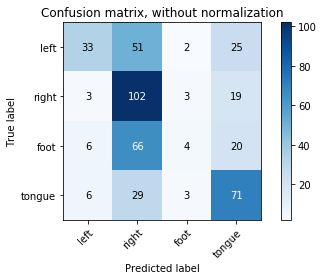

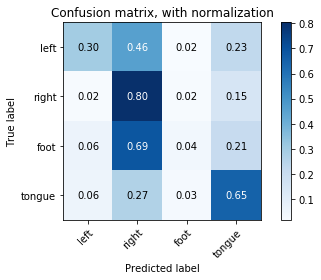

In [40]:
class_names = np.array(['left','right','foot','tongue'])
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true,y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
   # else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
plot_confusion_matrix(y_test, y_pred, classes=class_names,normalize=True,
                      title='Confusion matrix, with normalization')

In [31]:
y_test.shape
y_pred.shape

(443,)

(443,)

### The accuracy for each subject

In [41]:
data=np.zeros([9,1])
for i in range(9):
        data[i]=sum(y_pred[test_subject_idx[i]]==y_test[test_subject_idx[i]])/len(test_subject_idx[i])

column_name=['CNN++']
idx_name=['Subject_0', 'Subject_1','Subject_2','Subject_3','Subject_4','Subject_5','Subject_6','Subject_7','Subject_8']
df = pd.DataFrame(data=data,index=idx_name, columns=column_name)
df

,CNN++
Subject_0,0.340000
Subject_1,0.500000
Subject_2,0.420000
Subject_3,0.460000
Subject_4,0.531915
Subject_5,0.367347
Subject_6,0.680000
Subject_7,0.600000
Subject_8,0.361702
